In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder 


rc = {
    "axes.facecolor": "#FFFFFF",       
    "figure.facecolor": "#FFFFFF",
    "axes.edgecolor": "#000000",
    "grid.color": "#CCCCCC",
    "font.family": "malgun gothic",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc = rc)
plt.rc('axes', unicode_minus = False)

# **공연 수준을 정의해야 한다**

적정 그룹핑을 하기 전, 어떤 상황에 맞게 그룹핑을 할 것인지에 대한 전제 조건이 중요하다. 

공연의 예산에 따라서 그룹핑과 가격 비교를 하는 것이 맞지만

현재는 데이터의 익명성을 위해 공연의 정보를 특정 할 수 있는 정보가 없기 때문에 

공연의 평균 가격이 공연 기획자가 설정한 공연의 수준으로 지정하고 

공연의 평균 가격으로 공연을 분류하도록 하자

In [2]:
reservation_table = pd.read_parquet("C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/reservation_table.parquet")

In [3]:
display(reservation_table.head(3))
print(reservation_table.shape)

,전체공연시간,좌석 오픈 여부 sum,예매여부 sum,원가격추정 amin,원가격추정 mean,원가격추정 amax,거래까지걸린시간_시간 amin,거래까지걸린시간_시간 mean,거래까지걸린시간_시간 amax,공연 예매율,...,콘서트홀클래식_누적검색량,예술의전당클래식_누적검색량,서울클래식_누적검색량,연도,월,연 월,일,시간,요일,총_누적_검색량
0,2018-11-25 17:00:00,2505,1554,30000,67840.319361,100000,106.000000,370.685736,592.550000,0.620359,...,1000.0,0.0,50.0,2018,11,2018-11-01,25,17,6,1050.0
1,2018-12-08 17:00:00,2505,2159,20000,55277.445110,100000,131.566667,466.007264,880.766667,0.861876,...,980.0,0.0,60.0,2018,12,2018-12-01,8,17,5,1040.0
2,2019-01-11 20:00:00,2505,1592,50000,98778.443114,140000,-901.983333,-7.323775,691.650000,0.635529,...,1180.0,0.0,50.0,2019,1,2019-01-01,11,20,4,1230.0


(151, 26)


In [4]:
cols = ['원가격추정 mean', '공연 예매율'] # 공연의 분류를 두 가지 변수를 이용해 분류해보자 

example = reservation_table[cols]

display(example.head())
print(example.shape)

,원가격추정 mean,공연 예매율
0,67840.319361,0.620359
1,55277.445110,0.861876
2,98778.443114,0.635529
3,71992.015968,0.858283
4,26950.099800,0.475848


(151, 2)


Text(0.5, 1.0, '공연 평균 가격에 따른 예매율 산점도')

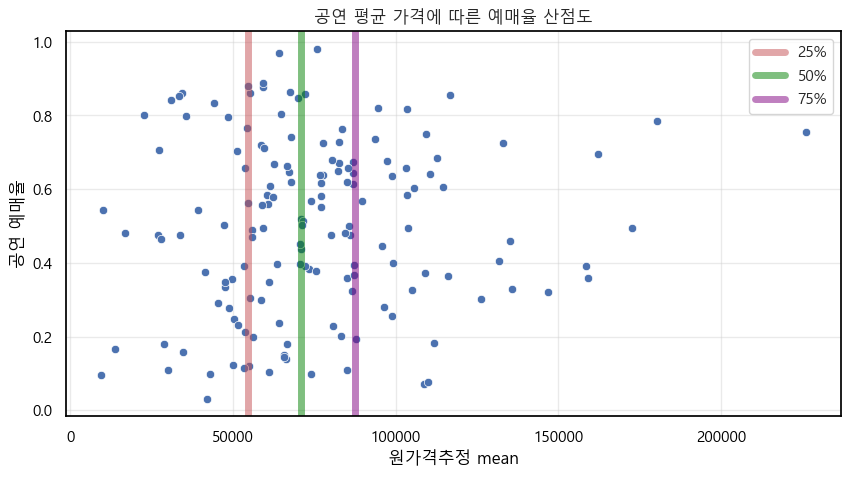

In [5]:
fig,ax = plt.subplots(figsize = (10,5))

sns.scatterplot(
    data = example,
    x = '원가격추정 mean',
    y = '공연 예매율'
)

ax.axvline(example['원가격추정 mean'].quantile(0.25), c = 'r', lw = 5, alpha = 0.5 ,label = '25%')
ax.axvline(example['원가격추정 mean'].quantile(0.5), c = 'green',lw = 5, alpha = 0.5, label = '50%')
ax.axvline(example['원가격추정 mean'].quantile(0.75), c = 'purple', lw = 5 , alpha = 0.5 , label = '75%')

ax.legend()
ax.set_title('공연 평균 가격에 따른 예매율 산점도')

공연 별 평균 좌석 가격 사분위수로 공연의 수준을 나눌 시 

공연의 객단가 별 그룹핑 전략으로 생각 할 수도 있을 것 같고 

샘풀의 개수도 유사하기 때문에 추후 예측 모델을 만들어 시뮬레이션 시에도 잘 될 것 같다.

네 공연의 분포는 일정할까 ? 

In [6]:
def quantile_conditioning(data,  col):
    '''
    특정 컬럼의 quantile 값으로 컨디셔닝 하여 
    reservation table 을 return 하는 함수 
    '''
    qunt_25 = data[col].quantile(0.25)
    qunt_5 = data[col].quantile(0.5)
    qunt_75 = data[col].quantile(0.75)
    
    under_25 = data.loc[data[col] <= qunt_25, '전체공연시간'].astype(str).unique()
    between_25_50= data.loc[(data[col] >= qunt_25) & (data[col] < qunt_5), '전체공연시간'].astype(str).unique()
    between_50_75 = data.loc[(data[col] >= qunt_5) & (data[col] < qunt_75), '전체공연시간'].astype(str).unique()
    over_75 = data.loc[data[col] >= qunt_75, '전체공연시간'].astype(str).unique()
    
    cross_table = pd.DataFrame(
        [str(qunt_25),f'{qunt_25} ~ {qunt_5}', f'{qunt_5} ~ {qunt_75}',f'{qunt_75} 이상'],
        index = ['하위 25%', '하위 25% ~ 하위 50%', '하위 50% ~ 하위 75%', '상위 25%'],
    )
    
    display(cross_table.T)
    
    return under_25, between_25_50, between_50_75, over_75

In [7]:
date_quantile = quantile_conditioning(reservation_table, col = '원가격추정 mean') # 공연 별 좌석 평균값을 사분위로 나눈 조건

quantiles = ['하위 25%이하', '하위 25% ~ 하위 50%', '하위50% ~ 하위 75%', '하위 75% 이상']

,하위 25%,하위 25% ~ 하위 50%,하위 50% ~ 하위 75%,상위 25%
0,54509.98003992016,54509.98003992016 ~ 70900.1996007984,70900.1996007984 ~ 87494.01197604791,87494.01197604791 이상


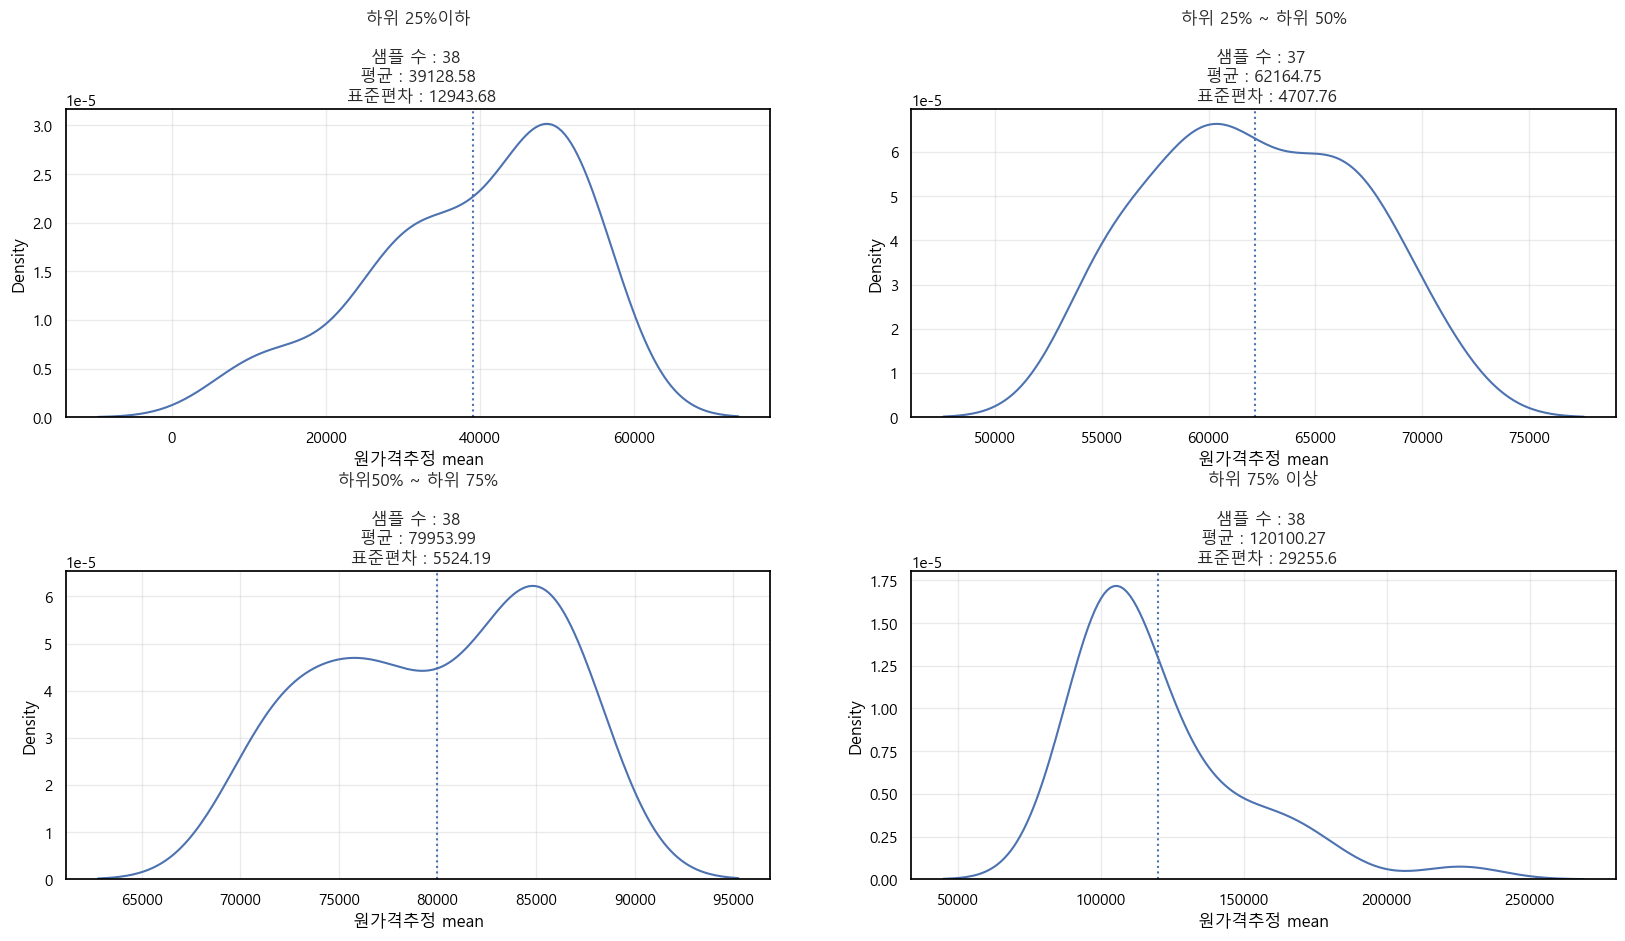

In [8]:
fig,ax = plt.subplots(figsize = (20,10), ncols = 2, nrows = 2)
ax = ax.flatten()
fig.subplots_adjust(hspace = 0.5)

graph_df = reservation_table.copy()
graph_df['전체공연시간'] = graph_df['전체공연시간'].astype(str)

for i,var in enumerate(quantiles):
    
    cond = graph_df['전체공연시간'].str.contains('|'.join(date_quantile[i]))
    
    cond_df = reservation_table[cond]
    
    samples = len(cond_df)
    mean = np.mean(cond_df['원가격추정 mean'])
    std = np.std(cond_df['원가격추정 mean'])
    
    sns.kdeplot(
        data = cond_df,
        x = '원가격추정 mean',
        ax = ax[i]
    )
    
    ax[i].set_title(quantiles[i] + '\n\n' + f'샘플 수 : {samples} \n 평균 : {round(mean,2)} \n 표준편차 : {round(std,2)}')
    ax[i].axvline(mean, ls = ':', label = '평균값')

샘플수도 비슷하고, 데이터의 분포도 심각하게 헤치지 않는 모습을 보인다 

이대로 공연을 분류하도록 해보자

In [9]:
df = pd.read_parquet("C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/거래까지걸린시간_추가_클래식_데이터.parquet")

In [10]:
df['공연분류'] = None 

for i in range(len(quantiles)):
    
    df['전체공연시간'] = df['전체공연시간'].astype(str)
    
    cond = df['전체공연시간'].str.contains('|'.join(date_quantile[i]))
    
    df.loc[cond, '공연분류'] = quantiles[i]    

In [11]:
display(df['공연분류'].value_counts() / 2505) # 기존 데이터 프레임에 공연분류를 설정한 후 저장

file_path = 'C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/'

df.to_parquet(file_path + '공연분류추가_클래식_데이터.parquet', index = False)

하위 75% 이상          38.0
하위50% ~ 하위 75%     38.0
하위 25%이하           38.0
하위 25% ~ 하위 50%    37.0
Name: 공연분류, dtype: float64